In [14]:

from net import GaussianDiffusion
from net import EpsilonTheta
from net import train_model
import torch
from torch.utils.data import DataLoader
import wandb
import math
from torch.optim.lr_scheduler import OneCycleLR
import optuna
import os
import matplotlib.pyplot as plt
#import tensorflow as tf
#from tensorflow.keras.callbacks import ReduceLROnPlateau

from tqdm import tqdm
import os

In [15]:
def custom_collate_fn(batch):
    """
    Custom collate function to reshape data into [batch size, channels, size].
    """
    # Assuming your signals are originally in the shape [size]
    # and you want to add a single channel dimension
    signals = torch.stack([item['signals'] for item in batch]).unsqueeze(1)  # Adds a channel dimension
    gt = torch.stack([item['gt'] for item in batch])
    sc = torch.stack([item['sc'] for item in batch])
    
    return {'signals': signals, 'gt': gt, 'sc': sc}

In [16]:
wandb.login()

True

In [23]:
wandb.init(project="test_train_2")

train_loss,█▆▆▅▅▅▅▄▄▄▃▃▁▁
train_loss,1.07737


In [24]:
learning_rate =  1e-3
batch_size = 128
num_layers = 15
residual_channels = 32
dilation_cycle_length = 2
nb_samples = 10000
num_batches_per_epoch = math.ceil(nb_samples / batch_size)

    
file_path = 'datasets/train_set.pth'
dataset = torch.load(file_path)

train_loader = DataLoader(dataset, batch_size=32, shuffle=True,collate_fn=custom_collate_fn)
    # Initialize model, optimizer, etc. using the suggested hyperparameters
    # For example:
denoise_fn = EpsilonTheta(target_dim=[256],
                              residual_layers=num_layers,
                              residual_channels=residual_channels,
                              dilation_cycle_length=dilation_cycle_length)
model = GaussianDiffusion(denoise_fn=denoise_fn, input_size=[256], beta_end=0.1, diff_steps=100, loss_type="l2", betas=None, beta_schedule="linear")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, min_lr=0.001)
lr_scheduler = OneCycleLR(
            optimizer,
            max_lr=learning_rate,
            steps_per_epoch=num_batches_per_epoch,
            epochs=400,
        )
    # Your training function should return the validation loss
val_loss = train_model(400, train_loader, num_batches_per_epoch, model, optimizer, lr_scheduler,
                validation_iter=None, device='cpu', model_save_path='./model_checkpoints_optuna_opt2/', 
                log_interval=100)
wandb.run.finish()


100%|██████████| 78/78 [00:35<00:00,  2.22it/s, epoch=100/400, avg_loss=0.0881]


Model saved to ./model_checkpoints_optuna_opt2/model_epoch_100.pth


100%|██████████| 78/78 [00:34<00:00,  2.23it/s, epoch=200/400, avg_loss=0.0785]


Model saved to ./model_checkpoints_optuna_opt2/model_epoch_200.pth


100%|██████████| 78/78 [00:40<00:00,  1.94it/s, epoch=300/400, avg_loss=0.0743]


Model saved to ./model_checkpoints_optuna_opt2/model_epoch_300.pth


100%|██████████| 78/78 [00:34<00:00,  2.24it/s, epoch=400/400, avg_loss=0.071] 


Model saved to ./model_checkpoints_optuna_opt2/model_epoch_400.pth


train_loss,█▅▄▄▂▂▃▂▂▂▂▂▂▁▂▁▂▂▂▂▁▂▂▁▂▂▂▂▂▁▂▂▂▁▂▁▂▂▁▁
train_loss,0.07531


In [25]:
model_path = './model_checkpoints_optuna_opt2/model_epoch_400.pth'  # Adjust the path and filename as necessary
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [26]:
model_path_2 = './model_checkpoints_optuna/model_epoch_100.pth'  # Adjust the path and filename as necessary
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [27]:
model.eval()


GaussianDiffusion(
  (denoise_fn): EpsilonTheta(
    (input_projection): Conv1d(1, 32, kernel_size=(1,), stride=(1,), padding=(2,))
    (diffusion_embedding): DiffusionEmbedding(
      (projection1): Linear(in_features=32, out_features=64, bias=True)
      (projection2): Linear(in_features=64, out_features=64, bias=True)
    )
    (residual_layers): ModuleList(
      (0): ResidualBlock(
        (dilated_conv): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (diffusion_projection): Linear(in_features=64, out_features=32, bias=True)
        (output_projection): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      )
      (1): ResidualBlock(
        (dilated_conv): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (diffusion_projection): Linear(in_features=64, out_features=32, bias=True)
        (output_projection): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      )
      (2): ResidualBlock(
        (dilated_conv): Conv1d(32, 64, kernel_size=(3,), s

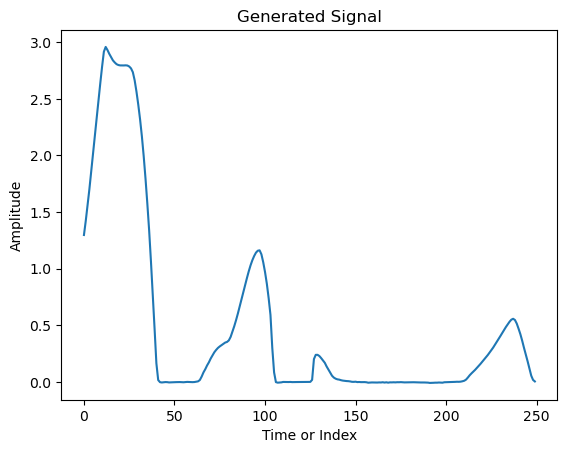

In [31]:
with torch.no_grad():  
    noise_shape = (10, 1, 250) 
    random_noise = torch.randn(noise_shape, device=model.betas.device)
    generated_signals = model.p_sample_loop(random_noise)
 
    plt.plot(generated_signals[3].squeeze().cpu().detach().numpy())
    plt.title("Generated Signal")
    plt.xlabel("Time or Index")
    plt.ylabel("Amplitude")
    plt.show()
